In [2]:
from scipy.stats import cauchy, bernoulli, norm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from math import gamma
import pandas as pd

from motion_filter.euclideanKF import *
from motion_filter.distutils import *
%matplotlib inline
plt.rcParams["figure.figsize"] = [10,10]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True 

# 1D Example

* Transition(Dynamics) Model
\begin{align}
x_t &= x_{t-1} + v_t*dt \\
v_t &= v_{t-1} + w_t \\
w_t &\sim \mathcal{N}(0,Q)
\end{align}
* Observaton Model
\begin{align}
y_t &= x_{t} + n_t \\
n_t &\sim (1- \alpha) \mathcal{N}(0,R) + \alpha \mathcal{C}(0, R')\,\,\alpha = [0,1]
\end{align}

In [3]:
#simulation setting

alpha = 0.002
C_scale = 10.0
N_scale = 0.1

dt = 0.001
end = 10 #sec
ts = np.linspace(0, end, int((end)/dt)+1)
tmp = 2 * np.pi * ( ts ** 2  * end - ts ** 3) * 0.05

pos = np.sin(tmp)
vel = np.cos(tmp) * 2 * np.pi * ( 2 * ts * end - 3 * ts ** 2) * 0.05

pos_gnoise = []
pos_lnoise = []

length = ts.shape[0]
for i in range(length):
    pos_gnoise.append(pos[i] + norm.rvs(loc=0.0, scale=N_scale))
    if (i%1000==0 or i%1000==1 or i%1000==2 or i%1000==3 or i%1000==4) and i>10:
        pos_lnoise.append(pos[i] + cauchy.rvs(loc=0.0, scale=C_scale))
    else:
        pos_lnoise.append(pos[i] + norm.rvs(loc=0.0, scale=N_scale))
pos_gnoise = np.array(pos_gnoise)
pos_lnoise = np.array(pos_lnoise)

### Overall Data

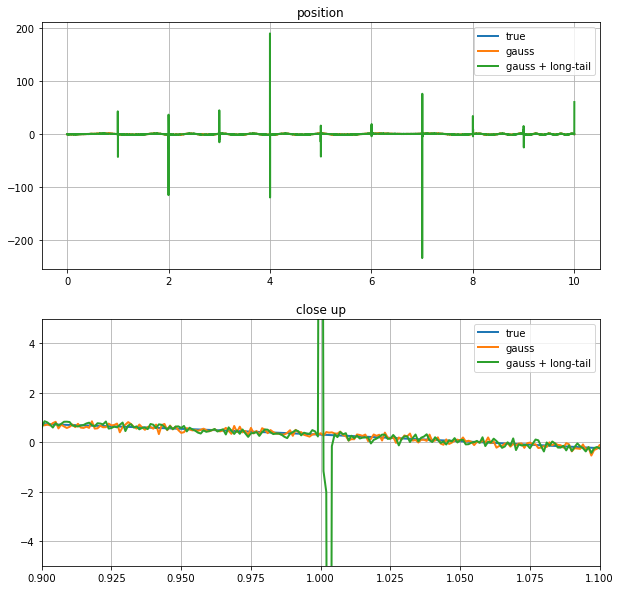

In [4]:
legend = ["true", "gauss", "gauss + long-tail"]

fig, axes = plt.subplots(2, 1)
axes[0].plot(ts, pos)
axes[0].plot(ts, pos_gnoise)
axes[0].plot(ts, pos_lnoise)
# axes[0].set_ylim([-2, 2])

axes[0].legend(legend)
axes[0].set_title("position")

# axes[1].plot(ts, vel)
axes[1].plot(ts, pos)
axes[1].plot(ts, pos_gnoise)
axes[1].plot(ts, pos_lnoise)
axes[1].legend(legend)
axes[1].set_title("close up")
axes[1].set_xlim([0.9, 1.1])
axes[1].set_ylim([-5.0, 5.0])

plt.show()

# Kalman Filter on Long-tail Data

In [5]:
m_noise_min = 0.1
m_noise_max = 100000.0

proccess_vel_noise = 0.1 ** 2
dim = 1


F = np.eye(dim * 2)
F[:dim, dim:] = np.eye(dim) * dt

Q = np.eye(dim * 2)
Q[:dim, dim:] = np.eye(dim) * dt
Q[dim:, :dim] = np.eye(dim) * dt
Q[:dim, :dim] = np.eye(dim) * dt * dt
Q = Q * proccess_vel_noise

H = np.zeros((dim, dim*2))
H[:dim, :dim] = np.eye(dim)
R_min = np.eye(dim) * m_noise_min
R_max = np.eye(dim) * m_noise_max

In [6]:
kf_under = KF(2, 1, F, H, Q, R_min, np.zeros(2), np.eye(2))
kf_over = KF(2, 1, F, H, Q, R_max, np.zeros(2), np.eye(2))

In [7]:
filtered_under_x = []
filtered_under_P = []

filtered_over_x = []
filtered_over_P = []

for i in range(length):
    kf_under.predict()
    kf_over.predict()
    
    kf_under.update2(pos_lnoise[i])
    kf_over.update2(pos_lnoise[i])
    
    filtered_under_x.append(kf_under.x.copy())
    filtered_under_P.append(kf_under.P.copy())
    
    filtered_over_x.append(kf_over.x.copy())
    filtered_over_P.append(kf_over.P.copy())


In [8]:
filtered_under_x = np.vstack(filtered_under_x)
filtered_over_x = np.vstack(filtered_over_x)

filtered_under_P = np.stack(filtered_under_P)
filtered_over_P = np.stack(filtered_over_P)


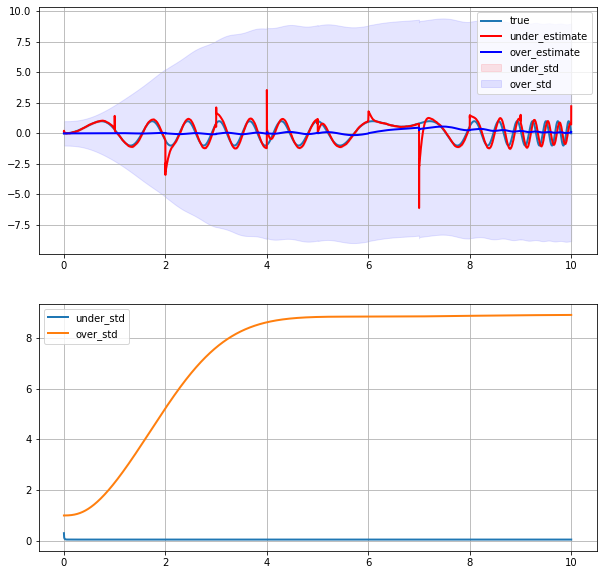

In [9]:
under_pos_error = np.sqrt(filtered_under_P[:, 0, 0])
over_pos_error = np.sqrt(filtered_over_P[:, 0, 0])

fig, axes = plt.subplots(2, 1)
axes[0].plot(ts, pos)
axes[0].plot(ts, filtered_under_x[:, 0],'r-')
axes[0].plot(ts, filtered_over_x[:, 0],'b-')

axes[0].fill_between(ts, filtered_under_x[:, 0] - under_pos_error, filtered_under_x[:, 0] + under_pos_error,alpha=0.1,color="red")
axes[0].fill_between(ts, filtered_over_x[:, 0] - over_pos_error, filtered_over_x[:, 0] + over_pos_error,alpha=0.1,color="blue")

# plt.plot(pos_error)
# plt.ylim([-1.2, 2])
axes[0].legend(["true", "under_estimate", "over_estimate", "under_std", "over_std"])

axes[1].plot(ts, under_pos_error)
axes[1].plot(ts, over_pos_error)
axes[1].legend(["under_std", "over_std"])

plt.show()
# axes[0].plot(ts, pos_gnoise)
# axes[0].plot(ts, pos_lnoise)

In [10]:
def f_cv(x):
    return F@x

def h_cv(x):
    return H@x

In [11]:
weight = 10.0/1000.0
sigma = MerweScaledSigmaPoints(2, 0.1, 2.0, 1.0)
ukf = UKF(2, f_cv, h_cv, sigma, Q, R_min, np.zeros(2), np.eye(2))
rukf = RUKF(2, f_cv, h_cv, sigma, Q, R_min, np.zeros(2), np.eye(2), weight, np.eye(1)*1.0)


ukf_x = []
ukf_P = []

rukf_x = []
rukf_P = []

for i in range(length):
    ukf.predict()
    rukf.predict()
    
    ukf.update(pos_lnoise[i:i+1])
    rukf.update(pos_lnoise[i:i+1])
    
    ukf_x.append(ukf.x.copy())
    ukf_P.append(ukf.P.copy())
    
    rukf_x.append(rukf.x.copy())
    rukf_P.append(rukf.P.copy())

ukf_x = np.vstack(ukf_x)
ukf_P = np.stack(ukf_P)

rukf_x = np.vstack(rukf_x)
rukf_P = np.stack(rukf_P)


## Robust Kalman Filter

modeling fat(long)-tail distribution in observation model

###### M. Wuthrich, S. Trimpe, D. Kappler, S. Schaal. A New Perspective and Extension of the Gaussian Filter. In Robotics: Science and Systems, 2015. http://arxiv.org/abs/1504.07941

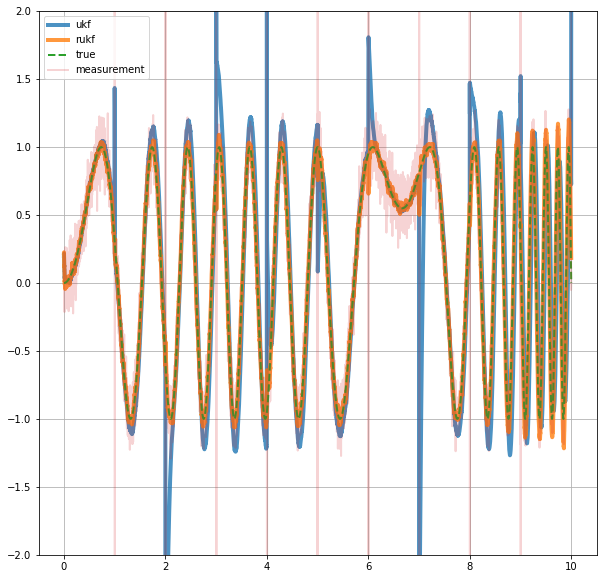

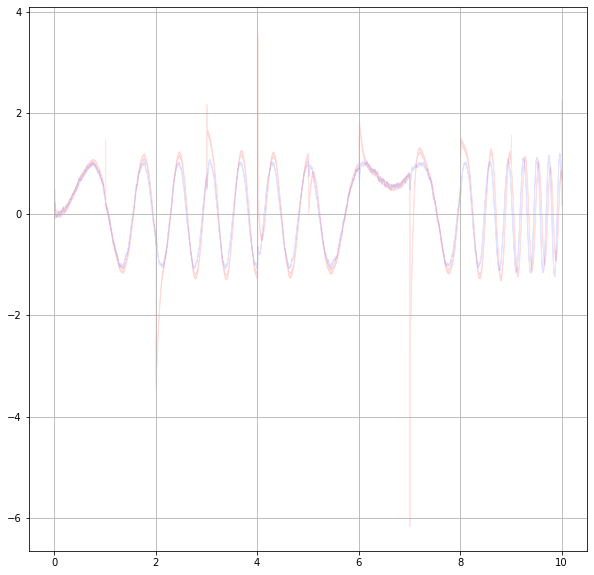

In [12]:
# %matplotlib qt
ukf_error = np.sqrt(ukf_P[:, 0, 0])
rukf_error = np.sqrt(rukf_P[:, 0, 0])

plt.plot(ts, ukf_x[:, 0], alpha=0.8, lw=4)
plt.plot(ts, rukf_x[:, 0], alpha=0.8, lw=4)
plt.plot(ts, pos, '--', alpha=1.0)
plt.plot(ts, pos_lnoise, alpha=0.2)
plt.ylim([-2, 2])
plt.legend(["ukf", "rukf", "true", "measurement"])
plt.show()

plt.fill_between(ts, ukf_x[:, 0] - ukf_error  , ukf_x[:, 0] + ukf_error       , alpha=0.1 , color="red")
plt.fill_between(ts, rukf_x[:, 0] - rukf_error, rukf_x[:, 0] + rukf_error , alpha=0.1,color="blue")

# Real Data
* real data contains outlier also bias in measurement

In [3]:
folder = "lpf_result"
keys = ["base", "chest", "head", "larm", "lhand", "rarm", "rhand"]

key = "larm"
r_df = pd.read_csv(f"../../data/{folder}/{key}_raw.csv")
f_df = pd.read_csv(f"../../data/{folder}/{key}_filter.csv")

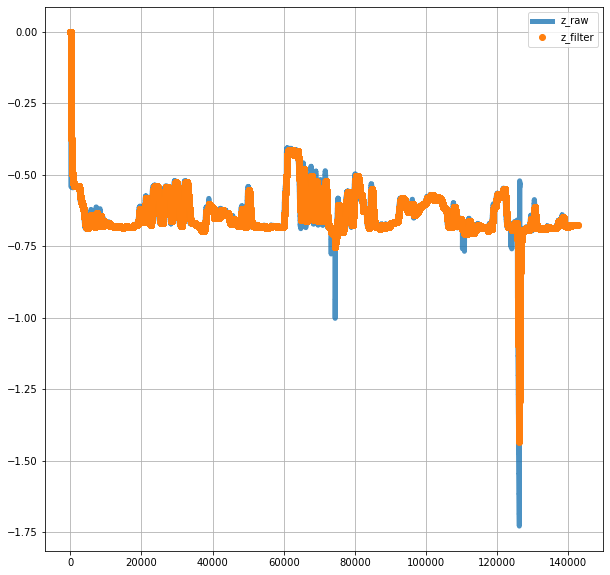

In [3]:
# %matplotlib qt
index = "z"
plt.plot(r_df[index], alpha=0.8, lw=5)
plt.plot(f_df[index],'o')
plt.legend([f"{index}_raw", f"{index}_filter"])


In [4]:
steps = 10.0
dt = 0.001 * steps
m_noise_ukf = 0.2 ** 2
m_noise_rukf = 0.5 ** 2

# proccess_vel_noise = 0.05 ** 2
proccess_accel_noise = 0.05 ** 2

dim = 1

Q = np.eye(dim * 2)

Q[:dim, :dim] = 0.25*np.eye(dim) * dt * dt* dt* dt
Q[:dim, dim:] = 0.5*np.eye(dim) * dt * dt* dt
Q[dim:, :dim] = 0.5*np.eye(dim) * dt* dt* dt
Q[:dim, :dim] = np.eye(dim) * dt * dt

# Q = Q * proccess_vel_noise
Q = Q * proccess_accel_noise


R_ukf = np.eye(dim) * m_noise_ukf
R_rukf = np.eye(dim) * m_noise_rukf

cauchy_P = np.eye(1)* 1000.0**2
#============================================================
F = np.eye(dim * 2)
F[:dim, dim:] = np.eye(dim) * dt


H = np.zeros((dim, dim*2))
H[:dim, :dim] = np.eye(dim)

In [5]:
def f_cv(x):
    return F@x

def h_cv(x):
    return H@x

In [6]:
weight = 0.001
sigma = MerweScaledSigmaPoints(2, 0.1, 2.0, 1.0)
ukf = UKF(2, f_cv, h_cv, sigma, Q, R_ukf, np.zeros(2), np.eye(2))
rukf = RUKF(2, f_cv, h_cv, sigma, Q, R_rukf, np.zeros(2), np.eye(2), weight, cauchy_P)

start = 80000
end = 140000

ukf.x = np.array([r_df["z"][start], 0.0])
rukf.x = np.array([r_df["z"][start], 0.0])

ukf_x = []
ukf_P = []

rukf_x = []
rukf_P = []

for i in range(start, end):
    if i%int(steps)==0:
        obs = np.array(r_df["z"][i:i+1])

    #     print(ukf.x)
    #     print(obs)
        ukf.predict()
        rukf.predict()


        ukf.update(obs)
        rukf.update(obs)

        ukf_x.append(ukf.x.copy())
        ukf_P.append(ukf.P.copy())

        rukf_x.append(rukf.x.copy())
        rukf_P.append(rukf.P.copy())

ukf_x = np.vstack(ukf_x)
ukf_P = np.stack(ukf_P)

rukf_x = np.vstack(rukf_x)
rukf_P = np.stack(rukf_P)

KeyboardInterrupt: 

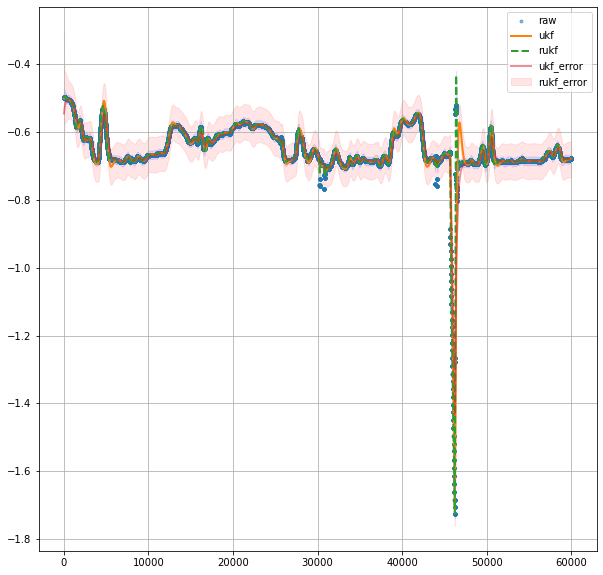

In [18]:
# %matplotlib qt
plt.plot(np.array(r_df["z"][start:end]),'.', alpha=0.5)
plt.plot(np.arange(end-start, step=int(steps)), ukf_x[:, 0], "-")
plt.plot(np.arange(end-start, step=int(steps)), rukf_x[:, 0], "--")

ukf_error = np.sqrt(ukf_P[:, 0, 0])
rukf_error = np.sqrt(rukf_P[:, 0, 0])

plt.fill_between(np.arange(end-start, step=int(steps)), ukf_x[:, 0] - ukf_error  , ukf_x[:, 0] + ukf_error       , alpha=0.1 , color="red")
plt.fill_between(np.arange(end-start, step=int(steps)), rukf_x[:, 0] - rukf_error, rukf_x[:, 0] + rukf_error , alpha=0.1,color="blue")
plt.plot(np.array(f_df["z"][start:end]), alpha=0.5)

plt.legend(['raw', 'ukf', 'rukf', "ukf_error", "rukf_error"])
# plt.savefig('/home/dhsung/exp_data/filter_pictures/real_data_larm.png', dpi = 300)


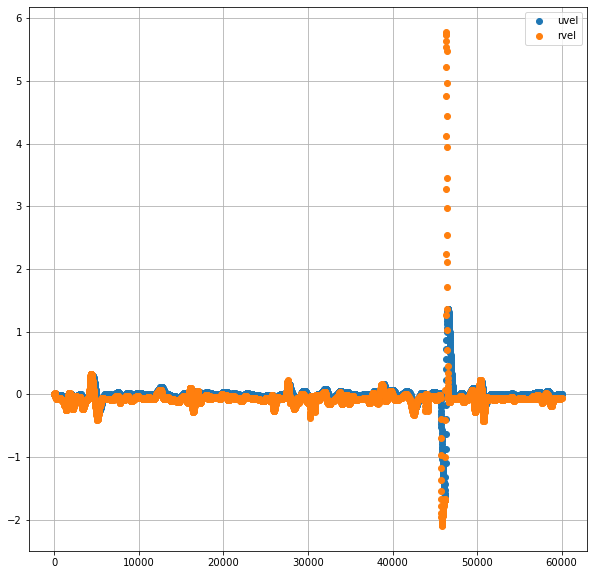

In [19]:
plt.plot(np.arange(end-start, step=int(steps)), ukf_x[:, 1], "o")
plt.plot(np.arange(end-start, step=int(steps)), rukf_x[:, 1], "o")
plt.legend(["uvel", "rvel"])
# plt.plot(np.arange(end-start, step=int(steps)), rukf_x[:, 1], "--")


# Bias Augmented Model

\begin{align}
\begin{bmatrix}
x_k \\ b_k
\end{bmatrix}
&= 
\begin{bmatrix}
F_k&0 \\ 0&I 
\end{bmatrix}
\begin{bmatrix}
x_{k-1} \\ b_{k-1}
\end{bmatrix}
+
\begin{bmatrix}
\mathcal{w}_k \\ \mathcal{\zeta}_{k}
\end{bmatrix}
~~~~ \mathcal{w}_k \sim \mathcal{N}(0,Q_k^x)~~\mathcal{\zeta}_k \sim \mathcal{N}(0,Q_k^b) \\
y_k &=
\begin{bmatrix}
H_k & C_k
\end{bmatrix}
+v_k ~~~~\mathcal{v}_k \sim \mathcal{N}(0,R_k)
\end{align}


In [4]:
steps = 10.0
dt = 0.001 * steps
m_noise_ukf = 0.05 ** 2

# proccess_vel_noise = 0.05 ** 2
proccess_accel_noise = 0.05 ** 2

dim = 1

Q = np.eye(dim * 2)

Q[:dim, :dim] = 0.25*np.eye(dim) * dt * dt* dt* dt
Q[:dim, dim:] = 0.5*np.eye(dim) * dt * dt* dt
Q[dim:, :dim] = 0.5*np.eye(dim) * dt* dt* dt
Q[:dim, :dim] = np.eye(dim) * dt * dt

# Q = Q * proccess_vel_noise
Q = Q * proccess_accel_noise


R = np.eye(dim) * m_noise_ukf

bias_noise = 0.01**2
Q_bias = np.eye(1) * dt * dt*bias_noise
#============================================================
F = np.eye(dim * 2)
F[:dim, dim:] = np.eye(dim) * dt

H = np.zeros((dim, dim*2))
H[:dim, :dim] = np.eye(dim)

In [5]:
correl = np.array([[-dt], [-1.0]])
dynM = np.block([[F, correl],
                 [np.zeros((1,2)), np.eye(1)]])
obsM = np.block([H, np.eye(1)*dt])

Q_aug = scipy.linalg.block_diag(Q, Q_bias)


# Kalman Filter

In [11]:
kf_filtered_x = []
kf_filtered_P = []
kf_filter_innov = []
kf_filter_innov_P = []
kf_z_scores = []

kf_bias = KF(2, 1, F, H, Q, R, np.zeros(2), np.eye(2)*0.01, 1.0)

start = 50000
end = 130000

kf_bias.x = np.array([r_df["z"][start], 0.0])

for i in range(start, end):
    if i%int(steps)==0:
        obs = np.array(r_df["z"][i:i+1])
        kf_bias.predict()
        inov, inovP = kf_bias.update2(obs)
        kf_filter_innov.append(inov)
        kf_filter_innov_P.append(inovP)
        
        z_score = inov @ (scipy.linalg.sqrtm(np.linalg.inv(inovP))).real
        kf_z_scores.append(z_score)
        
        kf_filtered_x.append(kf_bias.x.copy())
        kf_filtered_P.append(kf_bias.P.copy())

kf_filtered_x = np.vstack(kf_filtered_x)
kf_filter_innov = np.vstack(kf_filter_innov)

kf_filtered_P = np.stack(kf_filtered_P)
kf_filter_innov_P = np.stack(kf_filter_innov_P)

kf_z_scores = np.vstack(kf_z_scores)

# HUBER Kalman Filter

In [7]:
filtered_x = []
filtered_P = []
filter_innov = []
filter_innov_P = []
z_scores = []

kf_bias = RKF(2, 1, F, H, Q, R, np.zeros(2), np.eye(2)*0.01, 1.0)

start = 50000
end = 130000

kf_bias.x = np.array([r_df["z"][start], 0.0])

for i in range(start, end):
    if i%int(steps)==0:
        obs = np.array(r_df["z"][i:i+1])
        kf_bias.predict()
        inov, inovP = kf_bias.update(obs)
        filter_innov.append(inov)
        filter_innov_P.append(inovP)
        
        z_score = inov @ (scipy.linalg.sqrtm(np.linalg.inv(inovP))).real
        z_scores.append(z_score)
        
        filtered_x.append(kf_bias.x.copy())
        filtered_P.append(kf_bias.P.copy())

filtered_x = np.vstack(filtered_x)
filter_innov = np.vstack(filter_innov)

filtered_P = np.stack(filtered_P)
filter_innov_P = np.stack(filter_innov_P)

z_scores = np.vstack(z_scores)

In [14]:
%matplotlib qt
plt.rcParams["figure.figsize"] = [20,15]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True 
fig, axes = plt.subplots(4,1)
axes[0].set_title("position")
axes[0].plot(np.array(r_df["z"][start:end]),'.', alpha=0.5)
axes[0].plot(np.arange(end-start, step=int(steps)), kf_filtered_x[:, 0], "--")
axes[0].plot(np.arange(end-start, step=int(steps)), filtered_x[:, 0], "--")

error1 = np.sqrt(filtered_P[:, 0, 0])

axes[0].fill_between(np.arange(end-start, step=int(steps)), filtered_x[:, 0] - error1  , filtered_x[:, 0] + error1, alpha=0.3 , color="red")

axes[0].legend(['raw', 'kf', 'kf_huber'])

error2 = np.sqrt(filtered_P[:, 1, 1])
# error3 = np.sqrt(filtered_P[:, 2, 2])

axes[1].set_title("velocity")
axes[1].plot(np.arange(end-start, step=int(steps)), kf_filtered_x[:, 1], "--")
axes[1].plot(np.arange(end-start, step=int(steps)), filtered_x[:, 1], "-")

# axes[1].plot(np.arange(end-start, step=int(steps)), filtered_x[:, 2], "-")
axes[1].fill_between(np.arange(end-start, step=int(steps)), filtered_x[:, 1] - error2  , filtered_x[:, 1] + error2, alpha=0.3 , color="blue")
# axes[1].fill_between(np.arange(end-start, step=int(steps)), filtered_x[:, 2] - error3  , filtered_x[:, 2] + error3, alpha=0.3 , color="red")
axes[1].legend(['kf', 'kf_huber'])

error4 = np.sqrt(filter_innov_P[:, 0, 0])
axes[2].set_title("innovation")
axes[2].plot(np.arange(end-start, step=int(steps)), kf_filter_innov[:, 0])
axes[2].plot(np.arange(end-start, step=int(steps)), filter_innov[:, 0])
axes[2].legend(['kf', 'kf_huber'])

axes[2].fill_between(np.arange(end-start, step=int(steps)), 
                     filter_innov[:, 0] - error4  , filter_innov[:, 0] + error4, alpha=0.3 , color="red")

axes[3].set_title("Z_score")
axes[3].plot(np.arange(end-start, step=int(steps)), kf_z_scores,'.')
axes[3].plot(np.arange(end-start, step=int(steps)), z_scores,'.')
axes[3].legend(['kf', 'kf_huber'])

for i in range(4):
    axes[i].set_xlim([70000, 80000])

plt.savefig('/home/dhsung/exp_data/filter_pictures/edge_case_all.png', dpi = 300)


In [24]:
!jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True  'Robust Gaussian Filter.ipynb'

[NbConvertApp] Converting notebook Robust Gaussian Filter.ipynb to pdf
[NbConvertApp] Support files will be in Robust Gaussian Filter_files/
[NbConvertApp] Making directory ./Robust Gaussian Filter_files
[NbConvertApp] Making directory ./Robust Gaussian Filter_files
[NbConvertApp] Making directory ./Robust Gaussian Filter_files
[NbConvertApp] Making directory ./Robust Gaussian Filter_files
[NbConvertApp] Making directory ./Robust Gaussian Filter_files
[NbConvertApp] Writing 24818 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 294126 bytes to Robust Gaussian Filter.pdf


# Uncertainty Modeling in Lie Group(Manifold; non-Euclidean space)

### Notation
\begin{equation}
T = \begin{bmatrix}
R & p\\
\mathbf{0} & 1
\end{bmatrix}
\tau = [v, w]
\end{equation}

\begin{align}
\mathcal{T} \in SE(3) &\overset{Log(\bullet)}{\longrightarrow} \tau \in R^6 \\
\tau \in R^6 &\overset{Exp(\bullet)}{\longrightarrow} \mathcal{T} \in SE(3)
\end{align}

### Uncertainty on Lie Group

#### Setup

\begin{align}
&\zeta \sim \mathcal{N}(0,P), \zeta \in R^6 \\
&T = \bar{T}Exp(\zeta) \\
&T'=\bar{T}Exp(\zeta + \delta\zeta) \\
&T' \approx \bar{T}Exp(\zeta)Exp(\mathbf{J_r}(\zeta)\delta\zeta) \\
&T' \approx T Exp(\mathbf{J_r}(\zeta)\delta\zeta) \\
&\delta T = \mathbf{J_r}(\zeta)\delta\zeta
\end{align}

#### Sum up to 1

\begin{align}
1 &= \int p(\zeta)\, d\zeta \\
&= \int \eta \exp \Big(-\frac{1}{2} \zeta^T P^{-1} \zeta\Big) \, d\zeta \\
&= \int \beta \exp \Big(-\frac{1}{2} \mathbf{Log}(\bar{T}^{-1}T) P^{-1} \mathbf{Log}(\bar{T}^{-1}T)\Big) dT
\end{align}

#### Mean & Covariance

\begin{align}
0 &= \int \zeta p(\zeta)\, d\zeta \\
&= \int \mathbf{Log}(\bar{T}^{-1}T) p(T) dT \\
\end{align}

\begin{align}
P &= \int \zeta \zeta^T p(\zeta)\, d\zeta \\
&= \int \mathbf{Log}(\bar{T}^{-1}T)\mathbf{Log}(\bar{T}^{-1}T)^T p(T) dT \\
\end{align}

